# Learning the Gaussian Curve

In the notebook implementing the basic back propagation algorithm from scratch, I used as an example case of learning a gaussian curve. In theory, our model should be able to learn this well since there is no noise in the model (we are learning a deterministic function).

I will explore more robust approaches in deep learning to properly learn this gaussian curve. Some ideas I will try:

- Use more data
- Hyper-Parameter Testing
  - Number and Shape of Layers in the Network
  - Learning Rate
- Better Training Procedure: will use the Adam Algorithm instead of SGD


In [67]:
import numpy as np
import math
import matplotlib.pyplot as plt

from random import random
from time import time

## Defining a Gaussian Curve

In [68]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


In [69]:
num_points = 1000000

In [70]:
# We don't want the number of negative samples to overwhelm the
# number of positive examples since this can adversly affect the
# ability of the model to learn. Will downsample the dominant
# class.

# Note: c is a param that reduces the harshness of downsampling.
# When c == 1.0, downsampling approximately equalizes the positive
# and negative samples. As c gets larger, the dominant class
# is downsampled less. In the limit, c will perform no downsampling.
def downsample(points, labels, c=1.0):
    pos_mask = labels == 1
    neg_mask = labels == 0

    pos_count = np.sum(pos_mask)
    neg_count = np.sum(neg_mask)
    
    # Note: If values are inequal, gauranteed that one of the
    # following ratios will be 1.0 after clipping, which means
    # that the minority class won't get downsampled.
    neg_to_pos = min(1.0, neg_count / float(pos_count)) ** (1/c)
    pos_to_neg = min(1.0, pos_count / float(neg_count)) ** (1/c)
    
    random_values = np.random.rand(labels.shape[0])
    
    pos_keep_mask = (random_values < neg_to_pos) * pos_mask
    neg_keep_mask = (random_values < pos_to_neg) * neg_mask
    
    keep_mask = pos_keep_mask + neg_keep_mask
    
    return (points[:, keep_mask], labels[keep_mask])
    

In [71]:
gauss_func = create_gaussian_curve(0.0, 0.05)
points = np.random.rand(2, num_points) * 4 - 2
labels = np.apply_along_axis(lambda x: gauss_func(x[0], x[1]), axis=0, arr=points)

points, labels = downsample(points, labels, c=2)
n = points.shape[1]

random_assignment = np.random.rand(n)
train_mask = random_assignment <= 0.8
valid_mask = (random_assignment > 0.8) & (random_assignment <= 0.9)
test_mask = random_assignment > 0.9

train_data = points[:, train_mask]
train_labels = labels[train_mask]

valid_data = points[:, valid_mask]
valid_labels = labels[valid_mask]

test_data = points[:, test_mask]
test_labels = labels[test_mask]

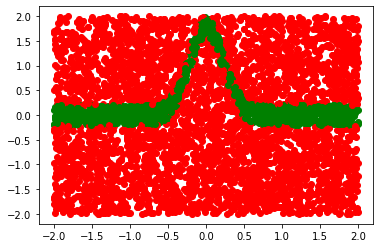

In [72]:
# Let's make a plot to see where the curve is being drawn.
# We will look at the first 5,000 points.

for i in range(5000):
    point = train_data[:, i]
    label = train_labels[i]
    plt.plot(point[0], point[1], 'go' if label == 1 else 'ro')

plt.show()

## Normalize Data

In [73]:
def normalizer(X0):
    """
    Generates a normalize and un-normalize function, which can be attached
    to a model. The normalization parameters are based on the training data.
    The model will automatically do the work of normalizing the data before
    it is fed into the network.
    
    X0 - The data used to normalize values. The data is of shape d x m, where
         d is the number of features and m is the number of samples.
    """
    
    m = X0.shape[1]
    mean = np.sum(X0, axis=1).reshape(-1, 1) / m
    variance = np.sum(X0 * X0, axis=1).reshape(-1, 1) / m
    std = np.sqrt(variance)

    def normalize(X):
        return (X - mean) / std

    return normalize
    

## Defining the Model

### Activation Functions

In [74]:
def relu(X):
    mask = X >= 0
    return X * mask


In [75]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [76]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [77]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [78]:
def binary_cross_entropy_loss(output, expected):
    # Offset the output if there are any values exactly equal to
    # zero or one to avoid log(0).
    zero_correct = (output == 0).astype(float) * 1e-10 
    one_correct = (output == 1).astype(float) * (-1e-10)
    output = output + zero_correct + one_correct

    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output))


In [79]:
def binary_cross_entropy_loss_grad(output, expected):    
    # Want to avoid divide by 0.
    epsilon = 1e-10
    zero_correct = (output == 0.0).astype(float) * epsilon
    one_correct = (output == 1.0).astype(float) * -epsilon
    output = output + zero_correct + one_correct
    
    return (-(expected / output) + (1 - expected) / (1 - output))


### Random Initialization

In [80]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers


### Model Functions

In [81]:
def forward(model, X_raw):
    X = model['normalize'](X_raw)
    Y = X

    linear_outputs = []
    outputs = []

    for weights, biases in model['layers'][0:-1]:
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    if 'no_grad' not in model or not model['no_grad']:
        model['linear_outputs'] = linear_outputs
        model['input'] = X
        model['outputs'] = outputs
        model['result'] = Y

    return Y
 

In [82]:
def predict(model, X):
    Y_hat = forward(model, X)
    return (Y_hat >= 0.5).astype(float).reshape(-1)
    

In [83]:
def backward(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    X = model['input']
    result = model['result']

    L = len(layers)
    m = result.shape[1] # Number of samples.

    # Keep track of error derivatives and gradients. These lists represent
    # the errors and gradients in reverse order with respect to the layers
    # in the network. The order is reversed after all the computations have
    # been completed.
    errors = []
    grads = []

    # Note: We can have multiple samples in the outputs, so we
    # will end up with a gradient per sample.
    loss_grad = binary_cross_entropy_loss_grad(result, expected)

    linear_output = linear_outputs[-1]
    output_prev_layer = X if len(outputs) <= 1 else outputs[-2]
    error_last_layer = loss_grad * sigmoid_deriv(linear_output)

    bias_grad = np.sum(error_last_layer, axis=1).reshape(-1, 1)
    weights_grad = np.dot(error_last_layer, output_prev_layer.T) # outer product
    grad_last_layer = (weights_grad, bias_grad)

    errors.append(error_last_layer)
    grads.append((weights_grad, bias_grad))

    # Enumerate layers in reverse order to compute errors
    # and gradients.
    for i in range(L - 2, -1, -1):
        linear_output = linear_outputs[i]
        output_prev_layer = X if i == 0 else outputs[i-1]
        error_next_layer = errors[-1]
        weights_next_layer, bias_next_layer = layers[i+1]

        error = np.dot(weights_next_layer.T, error_next_layer) * relu_deriv(linear_output)
        bias_grad = np.sum(error, axis=1).reshape(-1, 1)
        weights_grad = np.dot(error, output_prev_layer.T)
        
        errors.append(error)
        grads.append((weights_grad, bias_grad))
        
    # Reverse the order of errors and gradients so they go from
    # first layer to last.
    errors.reverse()
    grads.reverse()
    
    if 'no_grad' not in model or not model['no_grad']:
        model['errors'] = errors
        model['grads'] = grads
    
    return grads, errors


In [84]:
def loss(model, X, Y):
    output = forward(model, X)
    return binary_cross_entropy_loss(output, Y)
    

In [85]:
def gradient_clipping(model, threshold=1.0):
    """
    Returns True if the gradient was clipped, False otherwise.
    """
    l2_norm = 0

    for grad in model['grads']:
        grad_weight, grad_bias = grad
        l2_norm += np.sum(grad_weight * grad_weight)
        l2_norm += np.sum(grad_bias * grad_bias)
        
    l2_norm = math.sqrt(l2_norm)

    if l2_norm <= threshold:
        return False

    for (i, grad) in enumerate(model['grads']):
        grad_weight, grad_bias = grad

        grad_weight = grad_weight * threshold / l2_norm
        grad_bias = grad_bias * threshold / l2_norm

        model['grads'][i] = (grad_weight, grad_bias)
        
    return True
    
    

In [86]:
def grad_off(model):
    model['no_grad'] = True


In [87]:
def grad_on(model):
    model['no_grad'] = False


### Gradient Update

In [88]:
def step_SGD(model, epoch, batch_size, lr=0.1, lr_decay=0.0):
    # Note: We are assuming the model has already gone
    # through back propagation and all the gradients have
    # been calculated.
    
    new_layers = []

    lr = lr / (1 + lr_decay * epoch)

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]
        
        weight = weight - (lr / batch_size * grad_weight)
        bias = bias - (lr / batch_size * grad_bias)

        model['layers'][i] = (weight, bias)


In [89]:
def reset_Adam(model):
    # We keep track of exponential moving averages of our
    # Adam optimization algorithm, cached in the model.
    # If we are starting to train from scratch, we need
    # to know to set these averages to 0.
    mt = []
    vt = []

    for (i, layers) in enumerate(model['layers']):
        weight, bias = layers
        mt.append((np.zeros_like(weight), np.zeros_like(bias)))
        vt.append((np.zeros_like(weight), np.zeros_like(bias)))
        
    model['mt'] = mt
    model['vt'] = vt
    model['t'] = 0


In [90]:
def step_Adam(model, lr, batch_size, beta_1=0.9, beta_2=0.999, epsilon=1e-30):
    # Note: We are assuming the model has already gone through
    # back propagation and all the gradients have been calculated.
    
    t = model['t'] + 1

    one_minus_beta_1 = 1 - beta_1
    one_minus_beta_2 = 1 - beta_2

    one_minus_beta_1t = 1 - math.pow(beta_1, t)
    one_minus_beta_2t = 1 - math.pow(beta_2, t)

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]

        mt_minus_1_weight, mt_minus_1_bias = model['mt'][i]
        vt_minus_1_weight, vt_minus_1_bias = model['vt'][i]
        
        # Calculating exponentially moving averages.
        mt_weight = beta_1 * mt_minus_1_weight + one_minus_beta_1 * grad_weight
        mt_bias = beta_1 * mt_minus_1_bias + one_minus_beta_1 * grad_bias
        
        vt_weight = beta_2 * vt_minus_1_weight + one_minus_beta_2 * grad_weight * grad_weight
        vt_bias = beta_2 * vt_minus_1_bias + one_minus_beta_2 * grad_bias * grad_bias

        # Bias correction of our moving averages.
        mt_hat_weight = mt_weight / one_minus_beta_1t
        mt_hat_bias = mt_bias / one_minus_beta_1t
        vt_hat_weight = vt_weight / one_minus_beta_2t
        vt_hat_bias = vt_bias / one_minus_beta_2t

        # Calculate change in weights.
        deltat_weight = mt_hat_weight / (np.sqrt(vt_hat_weight) + epsilon)
        deltat_bias = mt_hat_bias / (np.sqrt(vt_hat_bias) + epsilon)
        
        # Update weights.
        weight = weight - (lr / batch_size * deltat_weight)
        bias = bias - (lr / batch_size * deltat_bias)

        # Write to model.
        model['layers'][i] = (weight, bias)
        model['mt'][i] = (mt_weight, mt_bias)
        model['vt'][i] = (vt_weight, vt_bias)

    
    model['t'] = t


## Monitoring

In [91]:
def calculate_weight_mag(model):
    n_params = 0
    weight_mag = 0

    for weight, bias in model['layers']:
        n_params += np.prod(weight.shape)
        n_params += np.prod(bias.shape)
        
        weight_mag += np.sum(weight * weight)
        weight_mag += np.sum(bias * bias)
        
    weight_mag = math.sqrt(weight_mag) / n_params

    return weight_mag


In [92]:
def calculate_grad_mag(model):
    n_params = 0
    grad_mag = 0
    
    for grad_weight, grad_bias in model['grads']:
        n_params += np.prod(grad_weight.shape)
        n_params += np.prod(grad_bias.shape)
        
        grad_mag += np.sum(grad_weight * grad_weight)
        grad_mag += np.sum(grad_bias * grad_bias)
        
    grad_mag = math.sqrt(grad_mag) / n_params
    
    return grad_mag
    
    

In [93]:
def calculate_confusion_matrix(model, X, Y):
    Y_hat = predict(model, X)

    tp = np.sum(((Y_hat == 1) & (Y == 1)).astype(float))
    tn = np.sum(((Y_hat == 0) & (Y == 0)).astype(float))
    fp = np.sum(((Y_hat == 1) & (Y == 0)).astype(float))
    fn = np.sum(((Y_hat == 0) & (Y == 1)).astype(float))

    # Rows are predictions, Columns are ground truth.
    return np.array([[tn, fn], [fp, tp]])


In [94]:
def calculate_precision_recall(model, X, Y):
    matrix = calculate_confusion_matrix(model, X, Y)
    tn = matrix[0, 0]
    fn = matrix[0, 1]
    fp = matrix[1, 0]
    tp = matrix[1, 1]
    
    precision = float(tp) / (tp + fn)
    recall = float(tp) / (tp + fp)
    
    return (precision, recall)


In [95]:
def calculate_accuracy(model, X, Y):
    Y_predicted = predict(model, X)
    m = Y.shape[0]
    return np.sum(Y_predicted == Y).astype(float) / m


In [96]:
def gradient_checking(model, X, Y, epsilon=1e-7):
    # Note: This function assumes that a gradient descent pass
    # has already hapenned. This check is super expensive and
    # should only be done for debugging.

    m = X.shape[1] # sample size

    total_params = 0
    total_error = 0
    
    for (l, layer) in enumerate(model['layers']):
        weights, biases = layer
        
        total_params += np.prod(weights.shape)
        total_params += np.prod(biases.shape)
        
        for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
                weight_orig = weights[i, j]
                
                weights[i, j] = weight_orig + epsilon
                loss_weight_up = loss(model, X, Y)
                
                weights[i, j] = weight_orig - epsilon
                loss_weight_down = loss(model, X, Y)
                
                estimated_grad = (loss_weight_up - loss_weight_down) / (2 * epsilon)
                diff = (model['grads'][l][0][i, j] - estimated_grad) / m
                total_error += (diff * diff)
                
                weights[i, j] = weight_orig
                
        for i in range(biases.shape[0]):
                bias_orig = biases[i]
                
                biases[i] = bias_orig + epsilon
                loss_bias_up = loss(model, X, Y)
                
                biases[i] = bias_orig - epsilon
                loss_bias_down = loss(model, X, Y)
                
                estimated_grad = (loss_bias_up - loss_bias_down) / (2 * epsilon)
                diff = (model['grads'][l][1][i] - estimated_grad) / m
                total_error += (diff * diff)
                
                biases[i] = bias_orig
               
    return math.sqrt(total_error) / total_params
            
    


## Creating and Training Model

In [97]:
def create_model(layer_sizes, normalize):
    model = {
        'layers': xavier_initialization(2, layer_sizes),
        'normalize': normalize,
    }

    return model


In [98]:
def train_model(model, train_data, train_labels, lr, batch_size, step_strategy, sgd_lr_decay, epochs=1000, logs=True, enable_mag_checking=False, enable_gradient_check=False):

    m = train_data.shape[1]

    train_errors = []
    grad_mags = []
    weight_mags = []

    reset_Adam(model)

    for i in range(epochs):
        if step_strategy == 'Adam':
            step_update = lambda model: step_Adam(model, lr=lr, batch_size=batch_size)
        else:
            step_update = lambda model: step_SGD(model, batch_size=batch_size, epoch=i, lr=lr, lr_decay=sgd_lr_decay)
        
        for (batch_i, batch_start) in enumerate(range(0, m, batch_size)):
            batch_X = train_data[:, batch_start:min(m, batch_start+batch_size)]
            batch_Y = train_labels[batch_start:min(m, batch_start+batch_size)]

            forward(model, batch_X)
            backward(model, batch_Y)
            # gradient_clipping(model, threshold=1.0)
            step_update(model)

        if i % 10 == 0:
            # Turn off gradient checking while we calculate training
            # and test loss.
            grad_off(model)

            train_output = forward(model, train_data)
            train_error = binary_cross_entropy_loss(train_output, train_labels) / m
            train_errors.append(train_error)

            if enable_mag_checking:
                grad_mag = calculate_grad_mag(model)
                weight_mag = calculate_weight_mag(model)

                grad_mags.append(grad_mag)
                weight_mags.append(weight_mag)

            if logs and i % 100 == 0:
                print(f'Epoch {i + 1}')
                print(f'Train Error={train_error}')
                
                if enable_mag_checking:
                    print(f'Weight Mag={weight_mag} Grad Mag={grad_mag}')

                if enable_gradient_check:
                    grad_check = gradient_checking(model, batch_X, batch_Y)
                    print(f'Grad Check={grad_check}')
                    
                print('')

            # Turn gradient checking back on before we start a new epoch.
            grad_on(model)

    return train_errors, weight_mags, grad_mags


In [99]:
models = []
valid_errors = []
train_error_logs = []
grad_mag_logs = []
weight_mag_logs = []

data = train_data[:, :100000]
labels = train_labels[:100000]

hyperparams = [
    {
        'batch_size': 100,
        'lr': 0.01,
        'layer_sizes': [80, 40, 8],
        'model_name': 'SGD Optimizer - No Decay',
        'sgd_lr_decay': 0.0,
        'step_strategy': 'SGD',
    },
    {
        'batch_size': 100,
        'lr': 0.01,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Adam Optimizer',
        'sgd_lr_decay': 0.0,
        'step_strategy': 'Adam',
    },
]

# For each set of hyper parameters, create and train a new model.
# Record the trained model with the corresponding validation error.
for (i, hyperparam) in enumerate(hyperparams):
    print(f'Training model {i + 1} / {len(hyperparams)}')
    print(f'Model = {hyperparam["model_name"]}')

    start_time = time()

    normalize = normalizer(data)
    model = create_model(hyperparam['layer_sizes'], normalize)

    # Pull out hyperparams
    lr = hyperparam['lr']
    batch_size = hyperparam['batch_size']
    step_strategy = hyperparam['step_strategy']
    sgd_lr_decay = hyperparam['sgd_lr_decay']

    train_errors, weight_mags, grad_mags = train_model(
        model,
        data,
        labels,
        lr=lr,
        batch_size=batch_size,
        step_strategy=step_strategy,
        sgd_lr_decay=sgd_lr_decay,
        enable_gradient_check=False)

    grad_off(model)

    train_error_logs.append(train_errors)
    weight_mag_logs.append(weight_mags)
    grad_mag_logs.append(grad_mags)

    valid_output = forward(model, valid_data)
    valid_error = binary_cross_entropy_loss(valid_output, valid_labels)

    grad_on(model)
    
    models.append(model)
    valid_errors.append(valid_error)

    end_time = time()

    print(f'Model took {(end_time - start_time) / 60:0.2f}m to train.')
    print('\n')



Training model 1 / 2
Model = SGD Optimizer - No Decay
Epoch 1
Train Error=0.20791183281551662

Epoch 101
Train Error=0.02151760160730857

Epoch 201
Train Error=0.013175298984082595

Epoch 301
Train Error=0.010414444806911253



/opt/anaconda3/envs/torch_1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 401
Train Error=0.008720144518884625

Epoch 501
Train Error=0.0077473011372085196

Epoch 601
Train Error=0.007343378324037344

Epoch 701
Train Error=0.007204982040090536

Epoch 801
Train Error=0.0073080779487765014

Epoch 901
Train Error=0.007179691843291248

Model took 8.38m to train.


Training model 2 / 2
Model = Adam Optimizer
Epoch 1
Train Error=0.3264440099473196

Epoch 101
Train Error=0.009470887848843897

Epoch 201
Train Error=0.0060075907295091885

Epoch 301
Train Error=0.004702357613630305

Epoch 401
Train Error=0.003968368325512186

Epoch 501
Train Error=0.0035183320872483118

Epoch 601
Train Error=0.00322561887289685

Epoch 701
Train Error=0.003016457220991862

Epoch 801
Train Error=0.0028601846886186087

Epoch 901
Train Error=0.002732150465924611

Model took 12.06m to train.




## Results

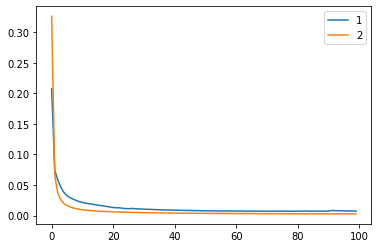

In [100]:
for (i, model) in enumerate(models):
    line = plt.plot(train_error_logs[i])

plt.legend([i + 1 for i in range(len(models))])

plt.show()

In [103]:
# Model with lowest validation error.
best_model_index = np.argmin(valid_errors)
best_model = models[best_model_index]
best_accuracy = calculate_accuracy(best_model, valid_data, valid_labels)

f'Model {best_model_index + 1} with accuracy {best_accuracy:.03f}'

/opt/anaconda3/envs/torch_1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


'Model 2 with accuracy 0.999'

In [104]:
precision, recall = calculate_precision_recall(best_model, valid_data, valid_labels)

f'Precision: {precision}, Recall: {recall}'

/opt/anaconda3/envs/torch_1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


'Precision: 0.9997005390297464, Recall: 0.9958238043154022'

/opt/anaconda3/envs/torch_1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


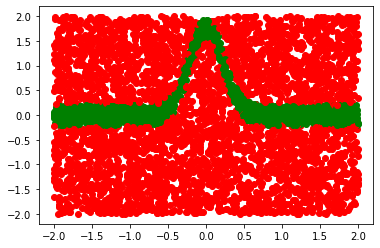

In [105]:
# Plot out predictions on test set.

test_predictions = predict(best_model, test_data)

for i in range(min(5000, test_data.shape[1])):
    point = test_data[:, i]
    predicted_label = test_predictions[i]
    # label = test_labels[i]
    plt.plot(point[0], point[1], 'go' if predicted_label == 1 else 'ro')

plt.show()